In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Solve HJB

In [4]:
# Intensity parameter
τ = 1.

r1 = 19.5001
r0 = .4

# Robustness parameters
ξ_b = 100000.
ξ_p = 5.
ξ_a = 1./100

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc+1]

In [6]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

-----Solving model 0-----
-----Solving model 1-----
-----Solving model 2-----
-----Solving model 3-----
-----Solving model 4-----
-----Solving model 5-----
-----Solving model 6-----
-----Solving model 7-----
-----Solving model 8-----
-----Solving model 9-----
-----Solving model 10-----
-----Solving model 11-----
-----Solving model 12-----
-----Solving model 13-----
-----Solving model 14-----
-----Solving model 15-----
-----Solving model 16-----
-----Solving model 17-----
-----Solving model 18-----
-----Solving model 19-----
-----Solving model 20-----
-----Solving model 21-----
-----Solving model 22-----
-----Solving model 23-----
-----Solving model 24-----
-----Solving model 25-----
-----Solving model 26-----
-----Solving model 27-----
-----Solving model 28-----
-----Solving model 29-----
-----Solving model 30-----
-----Solving model 31-----
-----Solving model 32-----
-----Solving model 33-----
-----Solving model 34-----
-----Solving model 35-----
-----Solving model 36-----
-----Solvin

In [14]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[0][-1]['v0'][:y_bar_upper_loc+1],
                               model_list[-1][-1]['v0'][:y_bar_upper_loc+1]]),
                     weights=np.array([0.5, 0.5]), axis=0)

In [8]:
np.max(ϕ_m)

4.604324101228557

In [16]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = - r0 * (np.exp(- r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

#         g = np.exp(1./ξ_2m*(v0-ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0) - np.exp(-1./ξ_2m * v0)) \
#                 / np.exp(-1./ξ_2m * v0)

        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [17]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 0.4970707527469629; RHS Error 0.49727862651266436
Iteration 2: LHS Error: 0.3609109226203546; RHS Error 0.36220505024688787
Iteration 3: LHS Error: 0.2740901056472267; RHS Error 0.27656309936050866
Iteration 4: LHS Error: 0.217868684860008; RHS Error 0.22093267052330307
Iteration 5: LHS Error: 0.18010133953239404; RHS Error 0.18399708461318431
Iteration 6: LHS Error: 0.15406092903582258; RHS Error 0.15777432300844607
Iteration 7: LHS Error: 0.13504791718167808; RHS Error 0.13883521898447843
Iteration 8: LHS Error: 0.12049782667206332; RHS Error 0.1247999756306126
Iteration 9: LHS Error: 0.1094942971875641; RHS Error 0.11384997497199066
Iteration 10: LHS Error: 0.10076835183866506; RHS Error 0.10446024461074199
Iteration 11: LHS Error: 0.09329492849520538; RHS Error 0.09773167372659504
Iteration 12: LHS Error: 0.08743815060591498; RHS Error 0.09136309184794028
Iteration 13: LHS Error: 0.08240726936087306; RHS Error 0.08647319638724207
Iteration 14: LHS Error: 0.0

Iteration 139: LHS Error: 0.010383505504387713; RHS Error 0.009948989821472354
Iteration 140: LHS Error: 0.010258096872949096; RHS Error 0.009835491178068943
Iteration 141: LHS Error: 0.01013986016373325; RHS Error 0.009720599027456062
Iteration 142: LHS Error: 0.010019652996630768; RHS Error 0.00960464372413565
Iteration 143: LHS Error: 0.009899833406781688; RHS Error 0.00949567075679706
Iteration 144: LHS Error: 0.009785787271634483; RHS Error 0.009385175857710294
Iteration 145: LHS Error: 0.009670392968459396; RHS Error 0.00927378466616608
Iteration 146: LHS Error: 0.009554871430145884; RHS Error 0.009168932598680062
Iteration 147: LHS Error: 0.00944536830434961; RHS Error 0.009063065268727667
Iteration 148: LHS Error: 0.009334973911661493; RHS Error 0.008956671247611792
Iteration 149: LHS Error: 0.009224428458359135; RHS Error 0.008854584513054473
Iteration 150: LHS Error: 0.009117665442114564; RHS Error 0.008753388993191329
Iteration 151: LHS Error: 0.009012330210754538; RHS Error

Iteration 257: LHS Error: 1.781668997313801e-05; RHS Error 0.0037337696678800894
Iteration 258: LHS Error: 1.580004963752657e-05; RHS Error 0.003733726252749786
Iteration 259: LHS Error: 1.4011102165589762e-05; RHS Error 0.0037336797396471666
Iteration 260: LHS Error: 1.24247732866678e-05; RHS Error 0.0037336321666638222
Iteration 261: LHS Error: 1.1018598859102724e-05; RHS Error 0.0037335850507105167
Iteration 262: LHS Error: 9.772475165092942e-06; RHS Error 0.003733539477263806
Iteration 263: LHS Error: 8.668430240277303e-06; RHS Error 0.003733496183672906
Iteration 264: LHS Error: 7.690414840055837e-06; RHS Error 0.0037334556331329247
Iteration 265: LHS Error: 6.824111708603198e-06; RHS Error 0.003733418078101479
Iteration 266: LHS Error: 6.056761837847091e-06; RHS Error 0.003733383613315752
Iteration 267: LHS Error: 5.377006390361316e-06; RHS Error 0.00373335221901204
Iteration 268: LHS Error: 4.774743175062213e-06; RHS Error 0.003733323795460354
Iteration 269: LHS Error: 4.2409964

Iteration 384: LHS Error: 5.9576743538514165e-08; RHS Error 0.0037330931979059415
Iteration 385: LHS Error: 5.397316105160144e-08; RHS Error 0.0037330932179865314
Iteration 386: LHS Error: 4.868213032693802e-08; RHS Error 0.003733093238744996
Iteration 387: LHS Error: 4.36983889073872e-08; RHS Error 0.0037330932600751
Iteration 388: LHS Error: 3.901576040021837e-08; RHS Error 0.003733093281870138
Iteration 389: LHS Error: 3.462723441316484e-08; RHS Error 0.0037330933040264982
Iteration 390: LHS Error: 3.0525058924979476e-08; RHS Error 0.003733093326444434
Iteration 391: LHS Error: 2.670084686684504e-08; RHS Error 0.003733093349032379
Iteration 392: LHS Error: 2.314564095939886e-08; RHS Error 0.003733093371696715
Iteration 393: LHS Error: 1.9850030064105795e-08; RHS Error 0.0037330933943534247
Iteration 394: LHS Error: 1.6804200697606575e-08; RHS Error 0.0037330934169146415
Iteration 395: LHS Error: 1.3998040948592916e-08; RHS Error 0.0037330934393102547
Iteration 396: LHS Error: 1.1421

## Simulation

In [23]:
e_grid_no_jump = model_res['e_tilde']
e_grid_jump_list = []
for i in range(n_model):
    temp = np.array([model['e_tilde'] for model in model_list[i]])
    e_grid_jump_list.append(temp)
e_grid_jump = np.array(e_grid_jump_list)

In [ ]:
def simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, γ_2p, n_model, T=100):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (n_model, M, N) ndarray
        e.g., e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    record_t = []
    for i in range(T+1):
        e_states = []
        y_states = []
        y_tilde_states = [] # -1 if no jump occurred
        γ_2p_states = [] # -1 if no jump occurred
        states_prob = []
        
        if y0 < y_bar_lower:
            e0 = np.interp(y0, y_grid_long, e_grid_no_jump)
            y0 = y0 + e0 * θ
            e_states.append(e)
            y_states.append(y)
            y_tilde_states.append(-1)
            γ_2p_states.append(-1)
            states_prob.append(1)
        else:
            intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
            jump_prob = τ * intensity
            
        
        for j, y0 in enumerate(y0_states):
            if γ_2p_states[j] == -1:
                
                
                
                
            if y0 <= y_bar_lower:
                y0 = y0 + et[i] * θ
            
    
    
    yt = np.zeros(T+1)
    et = np.zeros(T+1)
    damage_states_t = np.zeros(T+1)
    jump_occurred = False
    e_grid_realized = e_grid_no_jump
    for i in range(T+1):
        if y0 > y_bar_lower and jump_occurred == False:
            intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
            jump_prob = τ * intensity
            realized_jump_state = np.random.multinomial(n=1, pvals=np.array([jump_prob, 1-jump_prob]))
            if np.array_equal(realized_jump_state, np.array([1, 0])) or y0 > y_bar_upper:
                jump_occurred = True
                realized_damage_state = np.random.multinomial(n=1, pvals=damage_prob)
                loc = find_nearest_value(y_grid_tilde, y0)
                for i in range(n_model):
                    temp = np.zeros(n_model)
                    temp[i] = 1
                    if np.array_equal(realized_damage_state, temp):
                        e_grid_realized = e_grid_jump[i, loc]
                        damage_states_t[i:] = i + 1
        if jump_occurred:
            et[i] = np.interp(y0, y_grid_long, e_grid_realized)
        else:
            et[i] = np.interp(y0, y_grid_short, e_grid_realized)
        yt[i] = y0
        y0 = y0 + et[i]*θ
    return et, yt, damage_states_t

In [24]:
@njit
def simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, n_model, T=100):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (n_model, M, N) ndarray
        e.g., e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    yt = np.zeros(T+1)
    et = np.zeros(T+1)
    damage_states_t = np.zeros(T+1)
    jump_occurred = False
    e_grid_realized = e_grid_no_jump
    for i in range(T+1):
        if y0 > y_bar_lower and jump_occurred == False:
            intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
            jump_prob = τ * intensity
            realized_jump_state = np.random.multinomial(n=1, pvals=np.array([jump_prob, 1-jump_prob]))
            if np.array_equal(realized_jump_state, np.array([1, 0])) or y0 > y_bar_upper:
                jump_occurred = True
                realized_damage_state = np.random.multinomial(n=1, pvals=damage_prob)
                loc = find_nearest_value(y_grid_tilde, y0)
                for i in range(n_model):
                    temp = np.zeros(n_model)
                    temp[i] = 1
                    if np.array_equal(realized_damage_state, temp):
                        e_grid_realized = e_grid_jump[i, loc]
                        damage_states_t[i:] = i + 1
        if jump_occurred:
            et[i] = np.interp(y0, y_grid_long, e_grid_realized)
        else:
            et[i] = np.interp(y0, y_grid_short, e_grid_realized)
        yt[i] = y0
        y0 = y0 + et[i]*θ
    return et, yt, damage_states_t

@njit
def simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                      θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, n_model, T=80, N=10_000):
    yt_n_path = np.zeros((N, T+1))
    et_n_path = np.zeros((N, T+1))
    damage_states_t_n_path = np.zeros((N, T+1))
    for n in range(N):
        et, yt, damage_states_t = simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                                     θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, n_model=n_model, T=T)
        yt_n_path[n] = yt
        et_n_path[n] = et
        damage_states_t_n_path[n] = damage_states_t
    return et_n_path, yt_n_path, damage_states_t_n_path

In [59]:
et, yt, damage_states_t = simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
                           r1=r1, τ=τ, damage_prob=damage_setting['πd_o'], n_model=n_model, T=120, N=1_000_000)

## No jump plots

In [47]:
T = 91
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=T)

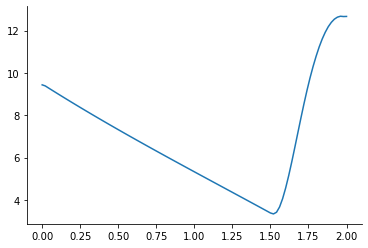

In [48]:
plt.plot(model_res['y_grid'], e_grid_no_jump)

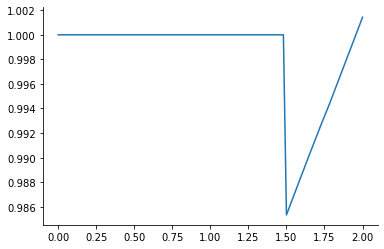

In [49]:
plt.plot(model_res['y_grid'], np.average(np.exp(-1./ξ_p*ϕ_m), weights=πd_o, axis=0))

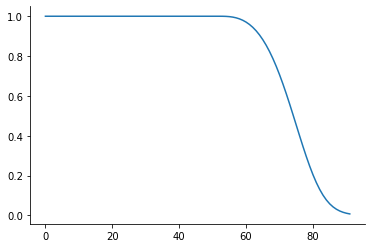

In [50]:
# Compute continuation probability
dt = 1./1
con_prob = np.ones(int(T/dt)+1)
time_periods = np.arange(0, T+dt, dt)
yt_no_jump_long = np.interp(time_periods, np.array(range(T+1)), yt_no_jump)
con_prob_sum = 0
for t in range(time_periods.shape[0]):
    y = yt_no_jump_long[t]
    if y >= y_bar_lower:
        intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        con_prob_sum += intensity * dt
        con_prob[t] = np.exp(-con_prob_sum)

# Plot continuation probability
plt.plot(time_periods, con_prob)

In [51]:
# Compute no jump probability
no_jump_prob = np.ones_like(yt_no_jump)
for t in range(no_jump_prob.shape[0]):
    y = yt_no_jump[t]
    if y > y_bar_lower:
        intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        no_jump_prob[t] = (1 - intensity*τ) * no_jump_prob[t-1]

In [52]:
# np.save('yt_03.npy', yt_no_jump)
# np.save('prob_03.npy', no_jump_prob)

Text(0.5, 0.98, '$r_0=0.4$')

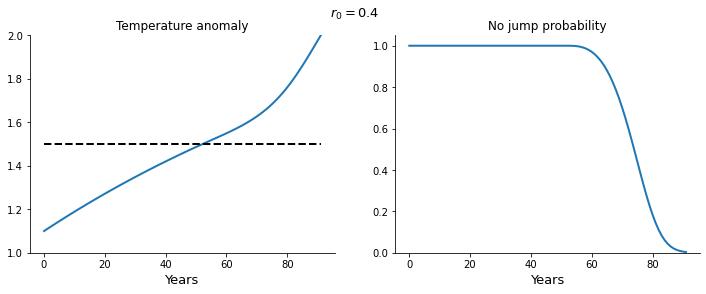

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(yt_no_jump, linewidth=2.)
ax1.plot(np.ones_like(yt_no_jump)*1.5, linestyle='dashed', color='black', linewidth=2)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_title(r'Temperature anomaly')
ax1.set_ylim(1, 2)

ax2.plot(no_jump_prob, linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_title(r'No jump probability')
ax2.set_ylim(0, 1.05)

fig.suptitle(r'$r_0=0.4$', fontsize=13)
# fig.savefig('fig.pdf')

In [84]:
no_jump_prob

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99987484, 0.99932023,
       0.99803576, 0.99572853, 0.99210414, 0.98686942, 0.97974031,
       0.97042859, 0.95864037, 0.94409812, 0.92653112, 0.90567407,
       0.88130128, 0.853215  , 0.82126607, 0.78538771, 0.74557883,
       0.70196117, 0.65477559, 0.60441724, 0.55144015, 0.49657

In [88]:
yt_no_jump

array([1.1       , 1.10918864, 1.11831081, 1.12736699, 1.13635768,
       1.14528336, 1.1541445 , 1.16294158, 1.17167507, 1.18034544,
       1.18895313, 1.19749861, 1.20598232, 1.21440471, 1.22276623,
       1.2310673 , 1.23930837, 1.24748986, 1.2556122 , 1.2636758 ,
       1.27168109, 1.27962847, 1.28751838, 1.29535119, 1.30312732,
       1.31084716, 1.31851112, 1.32611959, 1.33367295, 1.34117159,
       1.34861589, 1.35600623, 1.363343  , 1.37062655, 1.37785726,
       1.38503551, 1.39216165, 1.39923604, 1.40625906, 1.41323102,
       1.42015228, 1.42702321, 1.43384408, 1.44061525, 1.44733708,
       1.45400981, 1.46063382, 1.46720945, 1.47373699, 1.48021679,
       1.48664921, 1.49303456, 1.4993732 , 1.50566547, 1.51192993,
       1.51816873, 1.52438197, 1.53062002, 1.53690408, 1.5432345 ,
       1.54966284, 1.55624043, 1.56297073, 1.56989694, 1.57707642,
       1.58451841, 1.59227914, 1.60040371, 1.60891229, 1.61788532,
       1.62734816, 1.63736754, 1.64798838, 1.6592735 , 1.67127

In [46]:
def compute_prob(array):
    array_unique = np.unique(array)
    prob = np.zeros_like(array_unique)
    for i, point in enumerate(array_unique):
        prob[i] = np.sum(array==point)/len(array)
    return array_unique, prob

## Histograms

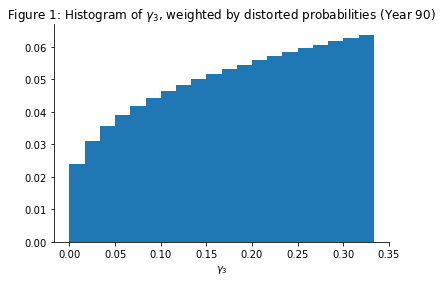

In [70]:
# Implied distorted probabilities
T_plot_new = 90
yt_loc = find_nearest_value(model_res['y_grid'], yt_no_jump[90])

Gt_m = model_res['g'][:, yt_loc]
πd = Gt_m*πd_o / np.sum(Gt_m*πd_o)
plt.hist(γ_2p, weights=πd, bins=20)
plt.xlabel(r'$\gamma_3$')
plt.title(r'Figure 1: Histogram of $\gamma_3$, weighted by distorted probabilities (Year 90)')
plt.savefig('fig_1.pdf')

In [62]:
# Compute probabilities
T_plot = 120
et_states, et_prob = compute_prob(et[:, T_plot])
yt_states, yt_prob = compute_prob(yt[:, T_plot])

In [110]:
# Compute probabilities
T_plot_new = 90
et_states_new, et_prob_new = compute_prob(et[:, T_plot_new])
yt_states_new, yt_prob_new = compute_prob(yt[:, T_plot_new])

Text(0.5, 1.0, 'Figure 2: Histogram of emission, Year 90')

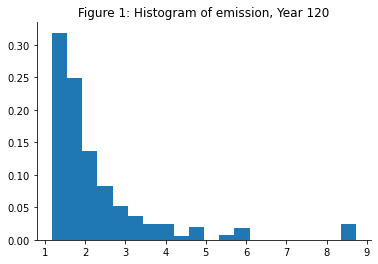

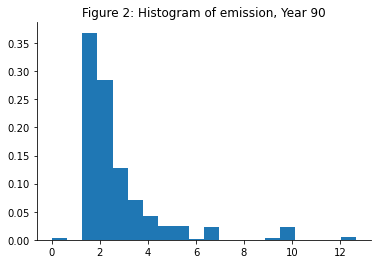

In [81]:
plt.figure()
plt.hist(et_states, weights=et_prob, bins=20)
plt.title('Figure 1: Histogram of emission, Year 120')

plt.figure()
plt.hist(et_states_new, weights=et_prob_new, bins=20)
plt.title('Figure 2: Histogram of emission, Year 90')

In [ ]:
yt_states_new

Text(0.5, 1.0, 'Figure 2: Histogram of temperature anomaly, Year 90')

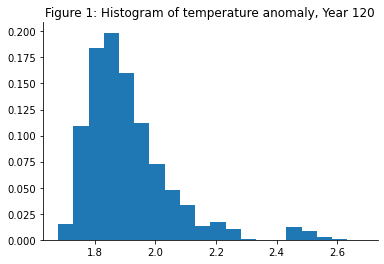

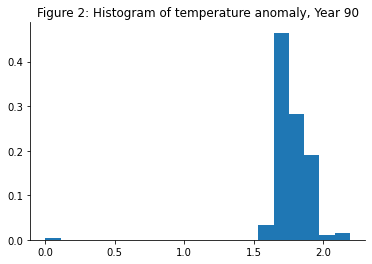

In [82]:
plt.figure()
plt.hist(yt_states, weights=yt_prob, bins=20)
plt.title('Figure 1: Histogram of temperature anomaly, Year 120')

plt.figure()
plt.hist(yt_states_new, weights=et_prob_new, bins=20)
plt.title('Figure 2: Histogram of temperature anomaly, Year 90')

Text(0.5, 1.0, 'Figure 2.1: Histogram of emission, Year 90')

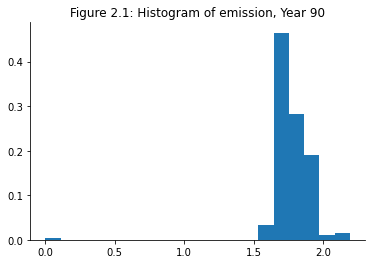